In [1]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

from GeospatialFM.datasets.ssl4eo.utils import get_ssl4eo_metadata
from GeospatialFM.data_process import apply_normalization, pretrain_transform, multimodal_collate_fn
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.models import PositionalChannelEmbedding
from GeospatialFM.datasets.ssl4eo import SSL4EODataset
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json
from safetensors import safe_open

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pca_vis_patch(patch, n_components=3):
    # perform PCA on patch
    pca = PCA(n_components=n_components)
    B, L, D = patch.shape
    patch_ = patch.reshape(B*L, D)
    try:
        patch_ = patch_.cpu().numpy()
    except:
        pass
    pca.fit(patch_)
    patch_pca = pca.transform(patch_)

    preprocessed_patches = patch_pca.reshape(B, int(L**0.5), int(L**0.5), 3)
    return preprocessed_patches

def norm_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

## SSL4EO

In [3]:
metadata = get_ssl4eo_metadata()
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]

In [4]:
dataset = dict(train=SSL4EODataset(root="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"))
apply_transform = partial(apply_normalization, optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std, use_8bit=False)
collate_fn = partial(multimodal_collate_fn, transform=pretrain_transform, normalization=apply_transform)

In [5]:
batch_size = 8

train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_fn
)

## Model

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    channel_embed_dims_per_head=2,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=6,
    decoder_num_heads=16,
    decoder_channel_embed_dims_per_head=2,
    use_perception_field_mask=True,
    attention_radius=320,
    norm_pix_loss=False,
    decoder_out_chans = 15,
    pos_chan_embed_residual=True,
)

# Initialize model
model = SpatialSpectralMAEViT(config)

## Training Code

In [7]:
# Set model to training mode
device = 'cuda:2'
model.to(device, dtype=torch.bfloat16)
model.train()
print()

In [8]:
# count the number of parameters
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 83219328
Number of parameters: 103478144


In [9]:
768*786*3*12

21731328

In [10]:
# load checkpoint
# model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-ViT-Decoder-all-channels-decoder-depth-1/checkpoint-1500/pytorch_model.bin", map_location=device))
# model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/archive/LRSSVIT-pos-res/checkpoint-500/pytorch_model.bin", map_location=device))

# Load the safetensors file
# with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-chan-dim-4/checkpoint-5000/model.safetensors", framework="pt", device=device) as f:
# with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT/checkpoint-22000/model.safetensors", framework="pt", device=device) as f:
# with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-chan-dim-2-archived/checkpoint-15500/model.safetensors", framework="pt", device=device) as f:
# with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-2-2-2-mse/checkpoint-4500/model.safetensors", framework="pt", device=device) as f:
# with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-2-2-2-add-norm/checkpoint-2000/model.safetensors", framework="pt", device=device) as f:
with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LESSVIT_b2_d6_multi/checkpoint-30000/model.safetensors", framework="pt", device=device) as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}

# Load the state dict into the model
model.load_state_dict(state_dict)
print("Model loaded successfully from safetensors file.")

# model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT-VITDecoder-no-channel-mask-depth-1/checkpoint-1500/pytorch_model.bin", map_location=device))


Model loaded successfully from safetensors file.


In [11]:
batch = next(iter(train_loader))
optical = batch['optical'].to(device, dtype=torch.bfloat16)
radar = batch['radar'].to(device, dtype=torch.bfloat16)
optical_channel_wv = batch['optical_channel_wv']
radar_channel_wv = batch['radar_channel_wv']
spatial_resolution = batch['spatial_resolution']

In [12]:
model.eval()
with torch.no_grad():
    x, cls_token, patch_tokens, hidden_states = model.encoder(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
x, cls_token, patch_tokens = x.to(torch.float32).detach().cpu(), cls_token.to(torch.float32).detach().cpu(), patch_tokens.to(torch.float32).detach().cpu()

In [13]:
pca_patches = []
for hidden_state in hidden_states:
    hidden_state = hidden_state.to(torch.float32)
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    patches = hidden_state[:, 0, 1:]
    # patches = hidden_state[:, 1, 1:]
    patches = pca_vis_patch(patches.numpy())
    pca_patches.append(patches)

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:685: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


/tmp/ipykernel_3344384/1257146177.py:18: RuntimeWarning: invalid value encountered in divide
  image = image / image.max()
/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


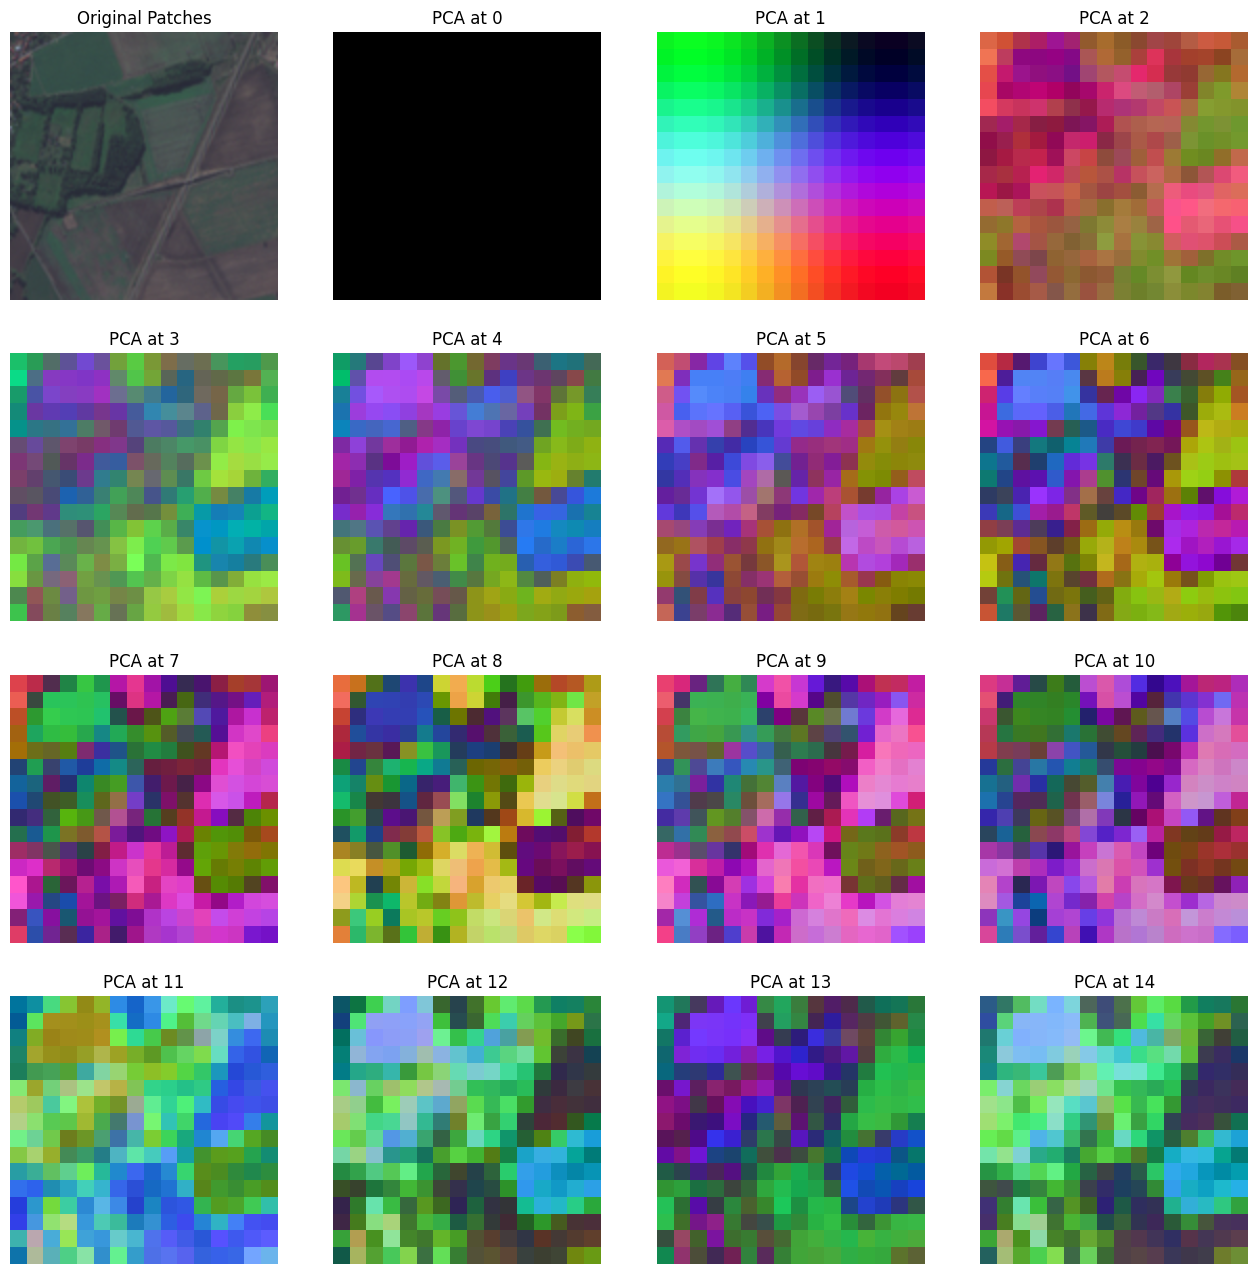

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

vis_idx = 4
for i in range(4):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')

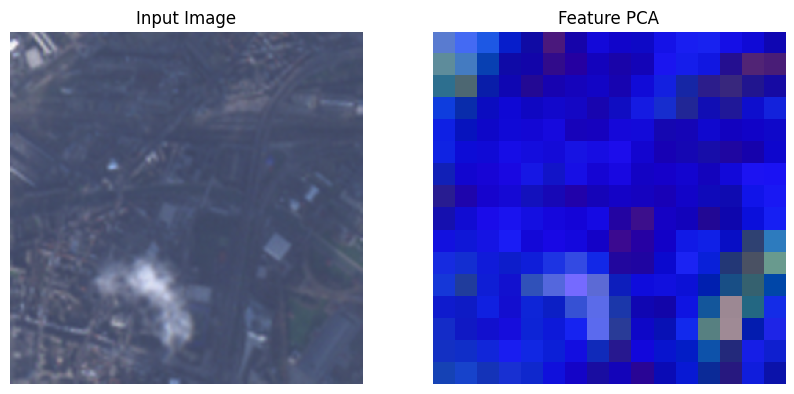

In [15]:
# visualize the first and the last PCA
vis_idx = 6
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(norm_image(pca_patches[-1][vis_idx]))
axs[1].set_title('Feature PCA')
axs[1].axis('off')
plt.show()


In [16]:
model.train()
with torch.no_grad():
    output = model(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, spatial_resolution=spatial_resolution, mask_ratio=0.75, channel_mask_ratio=0.5)


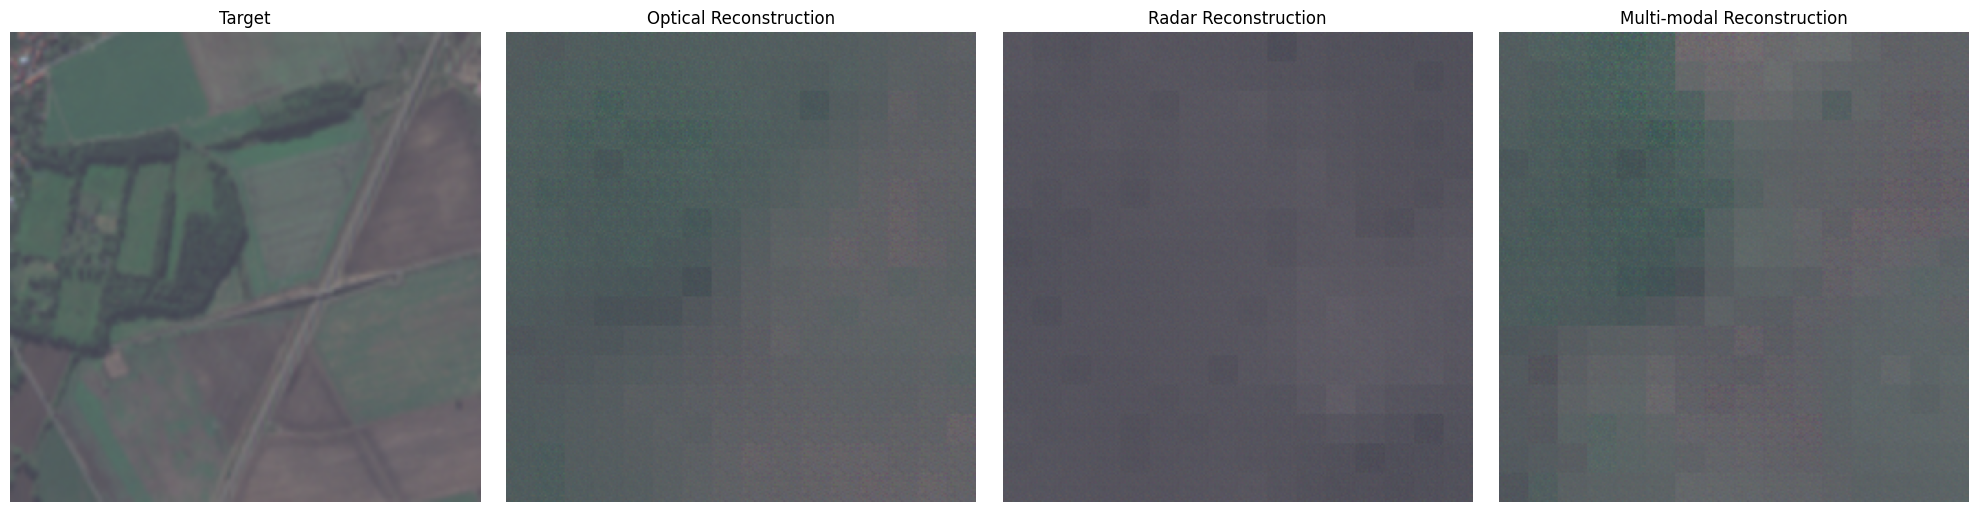

In [17]:
vis_idx = 4
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# all images are in RGB format
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
optical_img = model.decoder.unpatchify(output['optical_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
radar_img = model.decoder.unpatchify(output['radar_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)
multi_img = model.decoder.unpatchify(output['multi_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()[[3,2,1]].transpose(1,2,0)

# # normalize the images to be in [0, 1]
# target_img = norm_image(target_img)
# optical_img = norm_image(optical_img)
# radar_img = norm_image(radar_img)
# multi_img = norm_image(multi_img)

axs[0].imshow(target_img)
axs[0].set_title('Target')
axs[0].axis('off')

axs[1].imshow(optical_img)
axs[1].set_title('Optical Reconstruction')
axs[1].axis('off')

axs[2].imshow(radar_img)
axs[2].set_title('Radar Reconstruction')
axs[2].axis('off')

axs[3].imshow(multi_img)
axs[3].set_title('Multi-modal Reconstruction')
axs[3].axis('off')

plt.tight_layout()
plt.show()

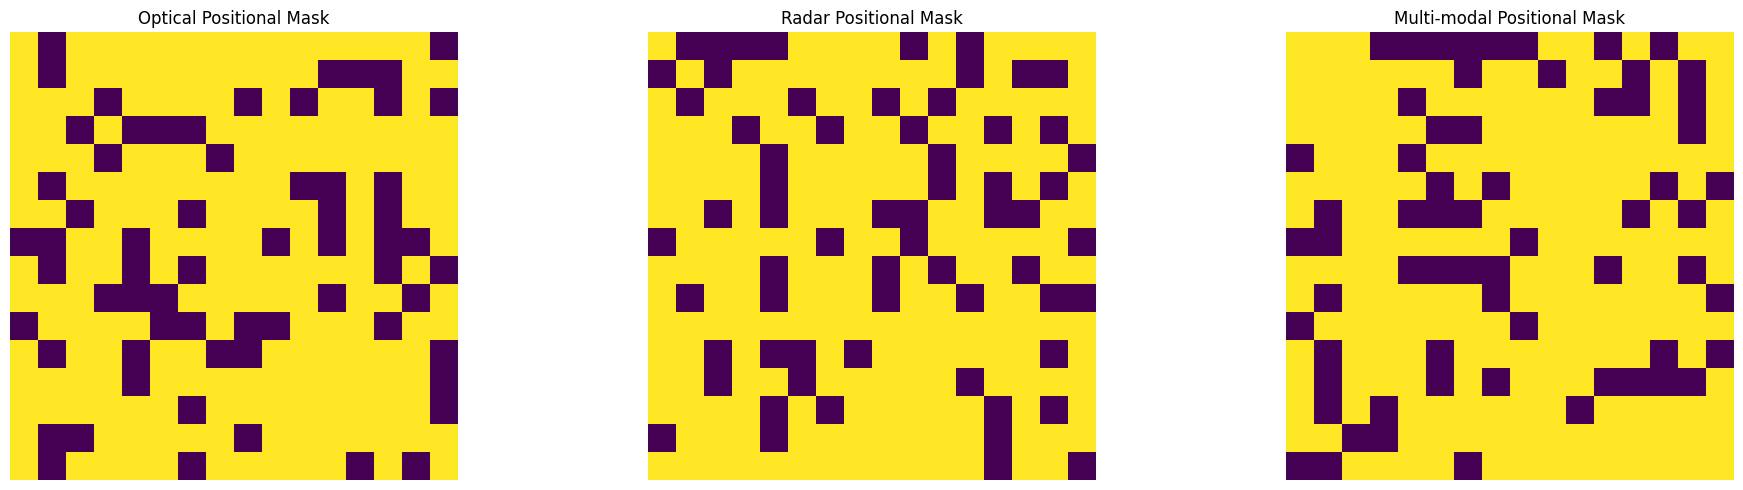

In [18]:
# visualize the spatial masks
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

n_patches = int(math.sqrt(output['optical_pos_mask'].shape[1]))

axs[0].imshow(output['optical_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[0].set_title('Optical Positional Mask')
axs[0].axis('off')

axs[1].imshow(output['radar_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[1].set_title('Radar Positional Mask')
axs[1].axis('off')

axs[2].imshow(output['multi_pos_mask'][vis_idx].detach().cpu().to(torch.float32).numpy().reshape(n_patches, n_patches))
axs[2].set_title('Multi-modal Positional Mask')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# output['multi_channel_mask'].shape
output['multi_pos_mask'].shape


torch.Size([8, 256])

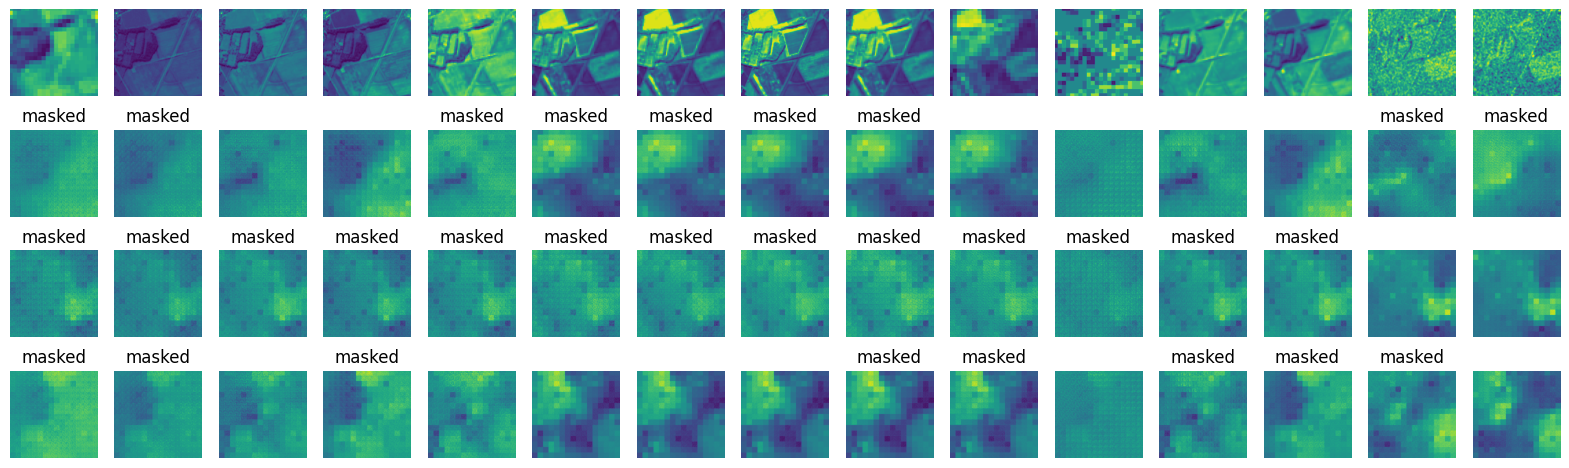

In [20]:
# visualize the reconstruction of every channel of every modality
vis_idx = 4
fig, axs = plt.subplots(4, 15, figsize=(20, 6))
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()
for i in range(15):
    axs[0, i].imshow(target_img[i])
    axs[0, i].axis('off')
for j, modal in enumerate(['optical', 'radar', 'multi']):
    spatial_mask = output[f'{modal}_pos_mask']
    masked_patches = output[f'{modal}_recon'] * spatial_mask.unsqueeze(1).unsqueeze(-1).expand_as(output[f'{modal}_recon'])
    unmasked_patches = output['target'] * (1-spatial_mask).unsqueeze(1).unsqueeze(-1).expand_as(output['target'])
    
    masked_channel_img = model.decoder.unpatchify(output[f'{modal}_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_img = model.decoder.unpatchify(masked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    unmasked_img = model.decoder.unpatchify(unmasked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_pos_img = unmasked_img + masked_img
    
    channel_mask = output[f'{modal}_channel_mask'][vis_idx].detach().cpu().to(torch.bool).numpy()
    for i in range(15):
        if channel_mask[i]:
            axs[j+1, i].imshow(masked_channel_img[i])
            axs[j+1, i].axis('off')
            axs[j+1, i].set_title('masked')
        else:
            # axs[j+1, i].imshow(masked_pos_img[i])
            axs[j+1, i].imshow(masked_channel_img[i])
            # axs[j+1, i].imshow(masked_img[i]) 
            axs[j+1, i].axis('off')
plt.show()

In [25]:
decoder_pca_patches = []
for hidden_state in output['multi_hidden_states']:
    hidden_state = hidden_state.to(torch.float32).detach().cpu()
    # patches = hidden_state[:, 1:, 1:].mean(dim=1)
    # patches = hidden_state[:, 2, 1:]
    patches = hidden_state[:, 0, 1:]
    # patches = hidden_state[:, 1:]
    patches = pca_vis_patch(patches.numpy())
    decoder_pca_patches.append(patches)

IndexError: list index out of range

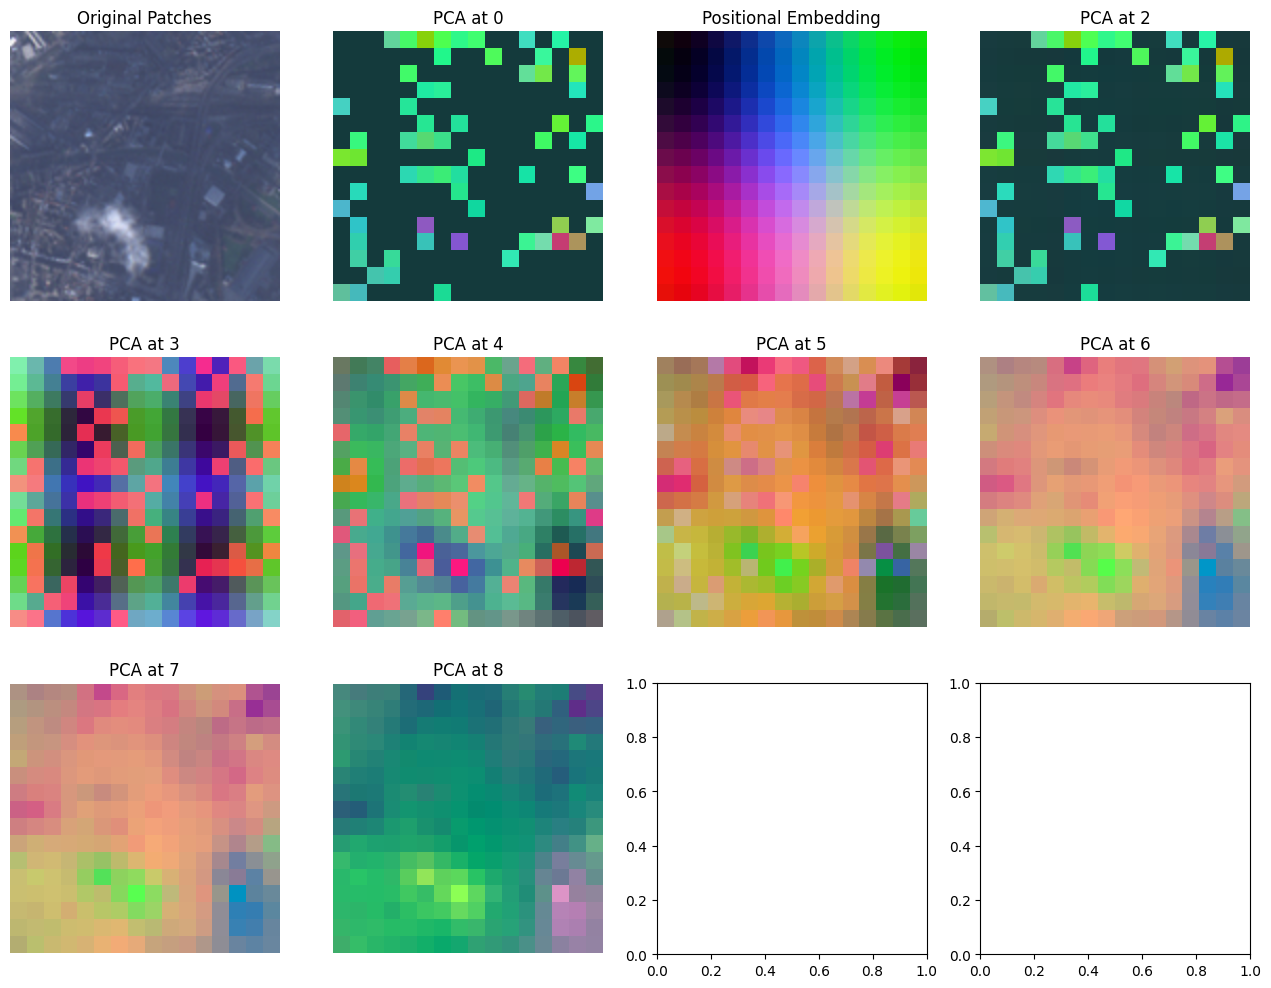

In [26]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

vis_idx = 6

for i in range(3):
    for j in range(4):
        index = i*4 + j
        if index == 0:
            axs[i, j].imshow(norm_image(optical[vis_idx].permute(1, 2, 0).to(torch.float32).detach().cpu().numpy())[..., [3,2,1]])
            axs[i, j].set_title('Original Patches')
            axs[i, j].axis('off') 
        elif index == 2:
            axs[i, j].imshow(norm_image(decoder_pca_patches[1][0]))
            axs[i, j].set_title('Positional Embedding')
            axs[i, j].axis('off')
        else:
            index -= 1
            axs[i, j].imshow(norm_image(decoder_pca_patches[index][vis_idx]))
            axs[i, j].set_title(f'PCA at {index}')
            axs[i, j].axis('off')
plt.show()